# Soft Actor Critic

#### Off Policy 

## Environment

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [-0.00554476  1.4094902  -0.56164026 -0.06355675  0.00643179  0.12722
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


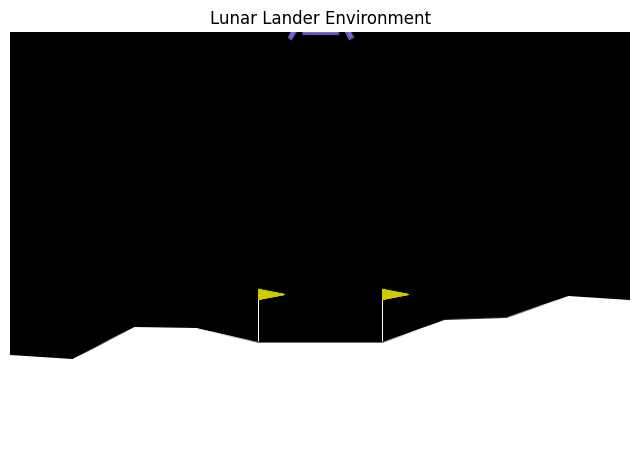

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(2):
    env.step(action=0)
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Plotting Helper

In [4]:
import matplotlib

In [5]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, policy_losses, value_losses, show_result=False, save_path=None):
    # Create a figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0, 0].set_title("Episode Durations")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Duration")
    axes[0, 0].plot(durations_t.numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0, 0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[0, 1].set_title("Rewards")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Reward")
    axes[0, 1].plot(rewards_t.numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[0, 1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 1].legend()

    # Plot Policy Loss
    policy_t = torch.tensor(policy_losses, dtype=torch.float)
    axes[1, 0].set_title("Policy Loss")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].plot(policy_t.numpy(), label="Policy Loss", color="orange")
    axes[1, 0].legend()

    # Plot Value Loss
    value_t = torch.tensor(value_losses, dtype=torch.float)
    axes[1, 1].set_title("Value Loss")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Loss")
    axes[1, 1].plot(value_t.numpy(), label="Value Loss", color="green")
    axes[1, 1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

## ReplayBuffer

In [6]:
from collections import namedtuple, deque
from typing import List, Deque
import random

# Define the type of the Transition tuple
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


# ReplayMemory class with strong type hints
class ReplayMemory:
    def __init__(self, capacity: int):
        # The deque stores Transition objects
        self.memory: Deque[Transition] = deque([], maxlen=capacity)

    def push(self, state: float, action: int, next_state: float, reward: float, done: bool) -> None:
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward, int(done)))

    def sample(self, batch_size: int) -> List[Transition]:
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Return the current size of the memory"""
        return len(self.memory)

In [7]:
import torch
from torch.optim import Adam, Optimizer
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from models import MLP
from typing import Tuple, Optional

import pandas as pd
from datetime import datetime
from numpy.typing import NDArray

In [8]:
torch.manual_seed(1)

## NN Weight Updates

In [9]:
def soft_update(target: nn.Module, source: nn.Module, tau: float) -> None:
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target: nn.Module, source: nn.Module) -> None:
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

## Policy Network

In [10]:
class PolicyNetwork(nn.Module):
    """
    Neural network for policy-based reinforcement learning.

    Architecture:
    - Input layer: Accepts `num_inputs` features representing the state.
    - Hidden layers: Two fully connected layers with 256 units each and ReLU activation for non-linearity.
    - Output layer: Produces `num_outputs`, representing action space size or logits.

    Args:
        num_inputs (int): Number of input features (state size).
        num_outputs (int): Number of output features (action size).

    Methods:
        forward(x): Propagates the input through the network.
    """

    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_inputs).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.net(x)

## Q Network

In [11]:
class QNetwork(nn.Module):
    def __init__(self, num_observations: int, num_actions: int):
        super(QNetwork, self).__init__()
        self.q1 = MLP(input_dim=num_observations, output_dim=num_actions)
        self.q2 = MLP(input_dim=num_observations, output_dim=num_actions)

    def forward(self, state: torch.Tensor):
        x1 = self.q1(state)
        x2 = self.q2(state)

        return x1, x2

## Soft-Actor-Critic

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from typing import Tuple


def soft_update(target_network: nn.Module, source_network: nn.Module, tau: float):
    for target_param, source_param in zip(target_network.parameters(), source_network.parameters()):
        target_param.data.copy_(tau * source_param.data + (1 - tau) * target_param.data)


class SoftActorCriticAgent:
    def __init__(
        self,
        actor_network: nn.Module,
        critic_network: nn.Module,
        target_critic_network: nn.Module,
        discount_factor_gamma: float = 0.99,
        soft_update_rate_tau: float = 0.05,
        learning_rate: float = 5e-4,
        num_actions: int = 4,
        initial_alpha: float = 1.0,
    ) -> None:
        self.discount_factor_gamma = discount_factor_gamma
        self.soft_update_rate_tau = soft_update_rate_tau

        self.actor_network = actor_network
        self.critic_network = critic_network
        self.target_critic_network = target_critic_network

        hard_update(self.target_critic_network, self.critic_network)
        self.num_actions = num_actions

        # Optimizers
        self.policy_optimizer = Adam(self.actor_network.parameters(), lr=learning_rate)
        self.critic_optimizer = Adam(self.critic_network.parameters(), lr=learning_rate)

        # Entropy coefficient (alpha) and its optimizer
        self.target_entropy = 0.98 * (-np.log(1.0 / self.num_actions))
        self.log_alpha = torch.tensor(np.log(initial_alpha), requires_grad=True)
        self.alpha_optimizer = Adam([self.log_alpha], lr=learning_rate)

    def get_action_probabilities(self, state: torch.Tensor) -> np.ndarray:
        with torch.no_grad():
            logits = self.actor_network(state)
            action_probabilities = F.softmax(logits, dim=-1)
        return action_probabilities.squeeze(0).cpu().numpy()

    def get_action(self, state: torch.Tensor, evaluation_episode: bool = False) -> int:
        if evaluation_episode:
            return self.get_action_deterministically(state)
        else:
            return self.get_action_stochastically(state)

    def get_action_stochastically(self, state: torch.Tensor) -> int:
        action_probabilities = self.get_action_probabilities(state)
        return np.random.choice(range(self.num_actions), p=action_probabilities)

    def get_action_deterministically(self, state: torch.Tensor) -> int:
        action_probabilities = self.get_action_probabilities(state)
        return int(np.argmax(action_probabilities))

    def get_action_info(self, states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Returns both probabilities and log probabilities
        logits = self.actor_network(states)
        action_probs = F.softmax(logits, dim=-1)
        log_action_probs = F.log_softmax(logits, dim=-1)
        return action_probs, log_action_probs

    def estimate_policy_values(self, states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # For the policy update, we use the current critic network
        action_probs, log_action_probs = self.get_action_info(states)
        q1_values, q2_values = self.critic_network(states)  # Current critics for policy improvement
        min_q_values = torch.min(q1_values, q2_values)
        return action_probs, log_action_probs, min_q_values

    def calculate_policy_loss(
        self, action_probs: torch.Tensor, log_action_probs: torch.Tensor, min_q_values: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        alpha = torch.exp(self.log_alpha)  # Compute alpha from log_alpha
        # Policy Loss: E[ sum_a pi(a|s) [alpha * log(pi(a|s)) - Q(s,a)] ]
        weighted_terms = alpha * log_action_probs - min_q_values
        policy_loss = (action_probs * weighted_terms).sum(dim=1).mean()
        return policy_loss, log_action_probs

    def estimate_q_values(
        self, states: torch.Tensor, actions: torch.Tensor, next_states: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Q-values for current states/actions
        q1_values, q2_values = self.critic_network(states)
        q1_current = q1_values.gather(1, actions).squeeze(1)
        q2_current = q2_values.gather(1, actions).squeeze(1)

        # Compute target Q-values
        with torch.no_grad():
            next_action_probs, next_log_action_probs = self.get_action_info(next_states)
            next_q1_values, next_q2_values = self.target_critic_network(next_states)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            alpha = torch.exp(self.log_alpha)
            # E_a [Q(s',a) - alpha * log_pi(a|s')]
            soft_state_value = (next_action_probs * (next_min_q_values - alpha * next_log_action_probs)).sum(dim=1)
            target_q_values = soft_state_value

        return q1_current, q2_current, target_q_values

    def calculate_q_value_loss(
        self,
        q1_current: torch.Tensor,
        q2_current: torch.Tensor,
        target_q_values: torch.Tensor,
        rewards: torch.Tensor,
        done: torch.Tensor,
    ) -> torch.Tensor:
        # Bellman update
        q_value_target = rewards.squeeze(-1) + self.discount_factor_gamma * (1 - done.squeeze(-1)) * target_q_values

        # MSE losses for both critics
        qf1_loss = F.mse_loss(q1_current, q_value_target)
        qf2_loss = F.mse_loss(q2_current, q_value_target)

        # Average the two Q-value losses
        qf_loss = 0.5 * (qf1_loss + qf2_loss)
        return qf_loss

    def optimize(
        self,
        states_batch: torch.Tensor,
        actions_batch: torch.Tensor,
        rewards_batch: torch.Tensor,
        next_states_batch: torch.Tensor,
        done_batch: torch.Tensor,
    ) -> Tuple[float, float, float]:
        # 1. Critic Optimization
        q1_current, q2_current, target_q_values = self.estimate_q_values(
            states=states_batch, actions=actions_batch, next_states=next_states_batch
        )

        q_value_loss = self.calculate_q_value_loss(
            q1_current=q1_current,
            q2_current=q2_current,
            target_q_values=target_q_values,
            rewards=rewards_batch,
            done=done_batch,
        )

        self.critic_optimizer.zero_grad()
        q_value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_network.parameters(), max_norm=1.0)
        self.critic_optimizer.step()

        # 2. Policy Optimization
        action_probs, log_action_probs, min_q_values = self.estimate_policy_values(states_batch)
        policy_loss, log_action_probs = self.calculate_policy_loss(action_probs, log_action_probs, min_q_values)

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_network.parameters(), max_norm=1.0)
        self.policy_optimizer.step()

        # 3. Alpha Optimization (Entropy Coefficient)
        # Compute the expected log_pi(s) under the current policy
        with torch.no_grad():
            expected_log_pi = (action_probs.detach() * log_action_probs.detach()).sum(dim=1)

        alpha_loss = -(self.log_alpha * (expected_log_pi + self.target_entropy)).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # 4. Soft-Update the Target Networks
        with torch.no_grad():
            soft_update(self.target_critic_network, self.critic_network, self.soft_update_rate_tau)

        return policy_loss.item(), q_value_loss.item(), alpha_loss.item()

## Neural Network Initialization

In [13]:
# Policy
policy_network = PolicyNetwork(n_observations, n_actions)

# Q Network Q1 and Q2
q_network = QNetwork(n_observations, n_actions)

# Target Q Network Q1_target and Q2_target
q_network_target = QNetwork(n_observations, n_actions)

# Hard update target initially so that Q networks have same weights in the beginning
hard_update(q_network_target, q_network)


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

device = torch.device("cpu")

# Send all NNs to device you have available and want to use
policy_network.to(device)
q_network.to(device)
q_network_target.to(device)

Using device:  mps


QNetwork(
  (q1): MLP(
    (fc_1): Linear(in_features=8, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=4, bias=True)
  )
  (q2): MLP(
    (fc_1): Linear(in_features=8, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=4, bias=True)
  )
)

## Hyperparameters

In [14]:
discount_factor_gamma = 0.99
soft_update_rate_tau = 0.01
batch_size = 256
learning_rate = 3e-4

In [15]:
soft_actor_critic_agent = SoftActorCriticAgent(
    actor_network=policy_network,
    critic_network=q_network,
    target_critic_network=q_network_target,
    discount_factor_gamma=discount_factor_gamma,
    soft_update_rate_tau=soft_update_rate_tau,
    learning_rate=learning_rate,
    num_actions=n_actions,
)

### Initialize Replay Memory

In [16]:
replay_memory = ReplayMemory(100000)

In [17]:
def collect_random(env: gym.Env, replay_memory: ReplayMemory, num_samples: int = 10000):
    """
    Populate the replay buffer with random experiences.

    Args:
        env: The environment.
        replay_memory: The replay buffer object.
        num_samples: Number of random samples to collect.

    "state", "action", "next_state", "reward", "done"
    """
    state, _ = env.reset()
    for _ in range(num_samples):
        # Sample a random action
        action = env.action_space.sample()
        # Take a step in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated

        # Add the transition to the replay buffer
        replay_memory.push(state, action, next_state, reward, done)
        # Update state
        if done:
            state, _ = env.reset()
        else:
            state = next_state

In [18]:
# collect_random(env, replay_memory, 10000)

print(len(replay_memory))

0


## Trainer

In [19]:
from typing import Dict, Optional


def record_data_and_train_on_a_batch(
    env: gym.Env,
    agent: "SoftActorCriticAgent",
    replay_memory: "ReplayMemory",
    device: torch.device,
    batch_size: int = 256,
) -> Dict[str, Optional[float]]:
    """
    Runs a single episode in the environment using the given agent, stores experience in the replay memory,
    and periodically trains the agent on a batch of sampled transitions.

    Args:
        env (gym.Env): The environment to interact with.
        agent (SoftActorCriticAgent): The SAC agent to be trained.
        replay_memory (ReplayMemory): The replay memory buffer storing experiences.
        device (torch.device): The device (CPU or GPU) for computation.
        batch_size (int): The batch size for training updates.

    Returns:
        Dict[str, Optional[float]]: A dictionary with metrics like average reward, losses, and steps.
    """

    global global_track_steps_per_episode, global_track_reward_per_episode, global_policy_loss, global_value_loss

    # Initialize episode metrics
    episode_reward = 0.0
    episode_steps = 0

    # Initialize training metrics
    policy_loss_sum = 0.0
    q_value_loss_sum = 0.0
    alpha_loss_sum = 0.0
    num_updates = 0

    train_every_n_steps = 1  # Optimize every 10 steps

    # Reset the environment
    state, _ = env.reset(seed=None)  # Ensure env.reset returns (obs, info)

    while True:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        # Get action from agent
        with torch.no_grad():
            action = agent.get_action(state=state_tensor)

        # Step in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_steps += 1
        episode_reward += reward

        # Store transition in replay buffer
        done = terminated or truncated
        replay_memory.push(state, action, next_state, reward, done)

        # Update current state
        state = next_state

        # Train the agent every N steps if we have enough samples
        if episode_steps % train_every_n_steps == 0 and len(replay_memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(batch.state, dtype=torch.float32, device=device)
            action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
            next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

            # Optimize the agent (policy, value, and alpha)
            policy_loss, q_value_loss, alpha_loss = agent.optimize(
                states_batch=state_batch,
                actions_batch=action_batch,
                rewards_batch=reward_batch,
                next_states_batch=next_state_batch,
                done_batch=done_batch,
            )

            policy_loss_sum += policy_loss
            q_value_loss_sum += q_value_loss
            alpha_loss_sum += alpha_loss
            num_updates += 1

        # Break if the episode is done
        if done:
            break

    # Update global trackers
    global_track_steps_per_episode.append(episode_steps)
    global_track_reward_per_episode.append(episode_reward)
    global_policy_loss.append(policy_loss_sum / max(1, num_updates))
    global_value_loss.append(q_value_loss_sum / max(1, num_updates))

    # Plot metrics after each episode (could be moved to a less frequent interval for performance)
    plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode, global_policy_loss, global_value_loss)

    # Compute and return metrics
    metrics = {
        "average_reward": episode_reward,
        "policy_loss": policy_loss_sum / max(1, num_updates),
        "q_value_loss": q_value_loss_sum / max(1, num_updates),
        "total_steps": episode_steps,
        "alpha_loss": alpha_loss_sum / max(1, num_updates),
    }

    return metrics

In [20]:
from datetime import datetime

# Generate a timestamp for model saving
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [21]:
def train(
    env: gym.Env,
    agent: SoftActorCriticAgent,
    replay_memory: ReplayMemory,
    device: torch.device,
    max_episodes: int = 500,
    reward_threshold: float = 200.0,
    rolling_window: int = 50,
    batch_size: int = 256,
    save_dir: str = "output",
) -> Tuple[List[float], List[float], List[int]]:
    """
    Trains the Soft Actor-Critic agent in the given environment.

    Args:
        env (gym.Env): The Gym environment.
        agent (SoftActorCriticAgent): The SAC agent.
        replay_memory (ReplayMemory): The replay memory buffer.
        device (torch.device): The device to run computations on.
        max_episodes (int, optional): Maximum number of episodes to train. Defaults to 500.
        reward_threshold (float, optional): Reward threshold for solving the environment. Defaults to 200.0.
        rolling_window (int, optional): Number of episodes to consider for rolling average. Defaults to 50.
        batch_size (int, optional): Number of samples per batch for training. Defaults to 256.
        updates_per_episode_recorded (int, optional): Number of optimization steps per episode. Defaults to 5.
        save_dir (str, optional): Directory to save the trained models. Defaults to "output".

    Returns:
        Tuple[List[float], List[float], List[int]]: Histories of rewards, losses, and steps per episode.
    """
    import os

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Initialize trackers
    rewards_history: List[float] = []
    loss_history: List[float] = []
    steps_history: List[int] = []

    best_average_reward: float = -np.inf  # Initialize to negative infinity

    for episode in range(1, max_episodes + 1):
        # Record data and perform training
        metrics = record_data_and_train_on_a_batch(
            env=env,
            agent=agent,
            replay_memory=replay_memory,
            device=device,
            batch_size=batch_size,
            # updates_per_episode_recorded=updates_per_episode_recorded,
        )

        # Collect metrics
        rewards_history.append(metrics.get("average_reward", 0.0))
        loss_history.append(metrics.get("policy_loss", 0.0))
        steps_history.append(metrics.get("total_steps", 0))

        # Calculate the average reward over the last 'rolling_window' episodes
        if len(rewards_history) >= rolling_window:
            avg_rolling_reward = np.mean(rewards_history[-rolling_window:])
        else:
            avg_rolling_reward = np.mean(rewards_history)

        # Print metrics every 5 episodes
        if episode % 5 == 0:
            current_loss = metrics.get("policy_loss", 0.0)
            current_steps = metrics.get("total_steps", 0)
            q_value_loss = metrics.get("q_value_loss", 0)
            print(
                f"Episode {episode}: Average Reward (last {min(rolling_window, len(rewards_history))} episodes): {avg_rolling_reward:.2f}, "
                f"Policy Loss: {current_loss:.4f}, Q Value Loss: {q_value_loss};Steps: {current_steps}"
            )

        # Convergence condition: Check if the rolling average exceeds the reward threshold
        if len(rewards_history) >= rolling_window and avg_rolling_reward >= reward_threshold:
            print(
                f"Environment solved in {episode} episodes! "
                f"Average reward over the last {rolling_window} episodes: {avg_rolling_reward:.2f}"
            )
            # Optionally, save the final model
            final_filename = os.path.join(save_dir, f"actor_critic_policy_final_{timestamp}.pth")
            torch.save(agent.policy_network.state_dict(), final_filename)
            print(f"Final model saved as: {final_filename}")
            break

        # Save the model if the current average reward is the best so far
        if avg_rolling_reward > best_average_reward:
            best_average_reward = avg_rolling_reward

            # Create a filename that includes the episode number and timestamp
            filename = os.path.join(save_dir, f"actor_critic_policy_{timestamp}.pth")

            # Save the policy network with the dynamically generated filename
            torch.save(agent.actor_network.state_dict(), filename)

            print(f"Episode: {episode}, Average reward: {avg_rolling_reward:.2f}. Model saved as: {filename}")

        # Optionally, plot metrics periodically or at the end
        # if episode % 50 == 0:
        #     plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode)

    env.close()

    return rewards_history, loss_history, steps_history

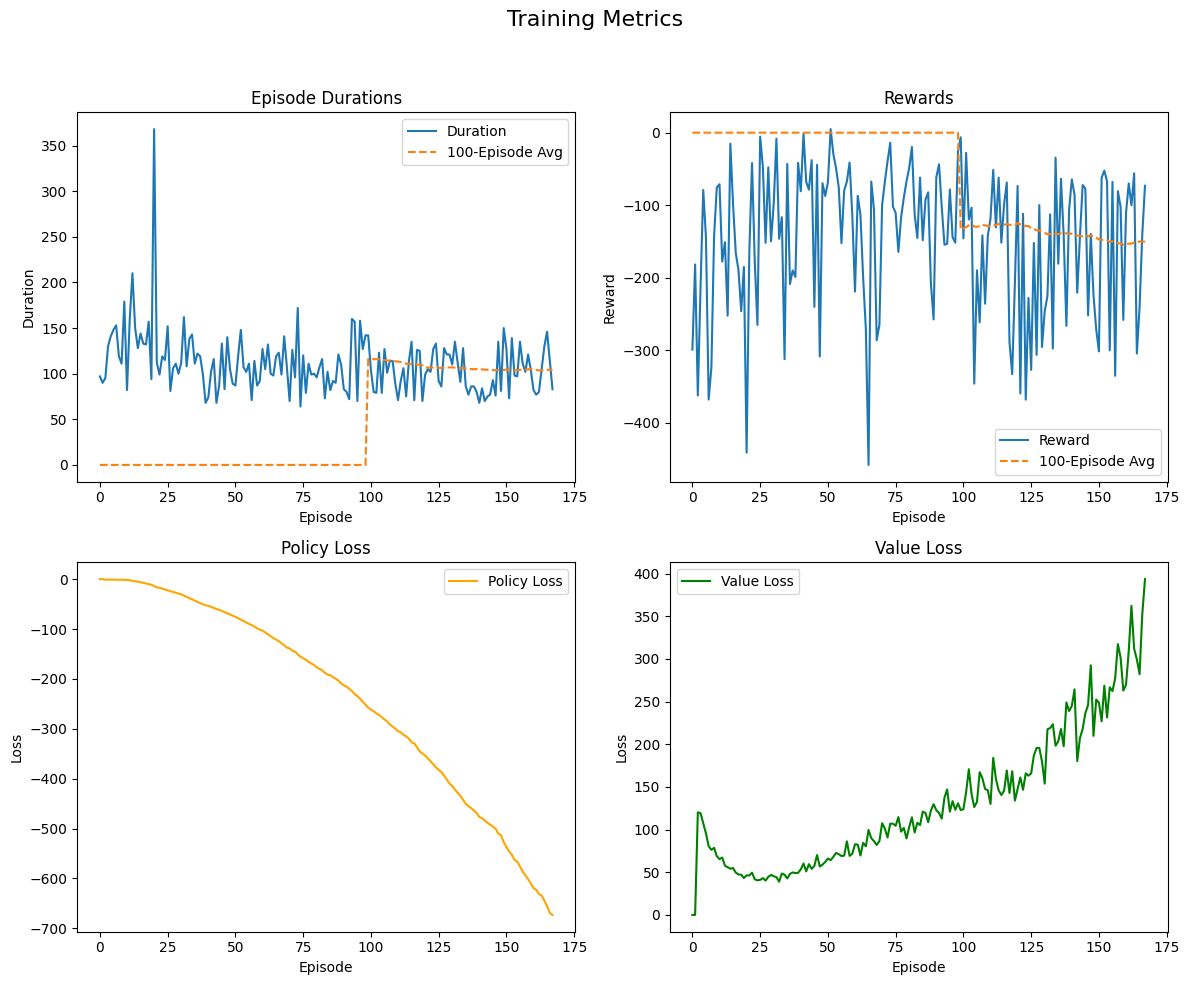

KeyboardInterrupt: 

In [22]:
max_episodes = 10000
reward_threshold = 200.0

global_track_steps_per_episode = []
global_track_reward_per_episode = []
global_policy_loss = []
global_value_loss = []

rewards_history, loss_history, steps_history = train(
    max_episodes=max_episodes,
    reward_threshold=reward_threshold,
    batch_size=batch_size,
    agent=soft_actor_critic_agent,
    device=device,
    replay_memory=replay_memory,
    env=env,
)

In [ ]:
plot_metrics(
    global_track_steps_per_episode,
    global_track_reward_per_episode,
    global_policy_loss,
    global_value_loss,
    save_path="plot",
)